<a href="https://colab.research.google.com/github/Ana-AlonsoCanizares/TU_Dortmund/blob/main/Assignment1_MonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from io import BytesIO
import zipfile
import os
# Parameters
a = 139
c = 150
m = 1890
x_0 = 485
N = 2000
x = np.arange(N)
x[0] = x_0
u = np.zeros(N)

In [4]:
for i in range (1,N):
  x[i] = (a*x[i-1] + c) % m

In [5]:
# Scaling the x values
def scaling(x,m,N):
    x = np.asarray(x, dtype=float)
    return x / float(m)

In [6]:
u = scaling(x,m,2000)

In [7]:
from scipy import stats

print("Mean =", np.mean(u))
print("Expected mean =", 0.5)
print("Variance =", np.var(u))
print("Expected variance =", 1/12)

ks_stat, ks_p = stats.kstest(u, 'uniform')
print("KS test statistic =", ks_stat)
print("p-value =", ks_p)

Mean = 0.5026455026455027
Expected mean = 0.5
Variance = 0.08284908037288989
Expected variance = 0.08333333333333333
KS test statistic = 0.034613756613756624
p-value = 0.016193770957103677


In [8]:
def lcg(a, c, m, seed, n):
    """Linear Congruential Generator: returns list of x's (integers)."""
    xs = []
    x = seed % m
    for _ in range(n):
        x = (a * x + c) % m
        xs.append(int(x))
    return xs

In [9]:
def lcg_period(a, c, m, seed, max_iter=10_000_000):
    """Estimate period by simulating until first repeat of seed (or until max_iter)."""
    seen = set()
    x = seed % m
    for i in range(1, max_iter+1):
        x = (a * x + c) % m
        if x == seed % m:
            return i
    return None

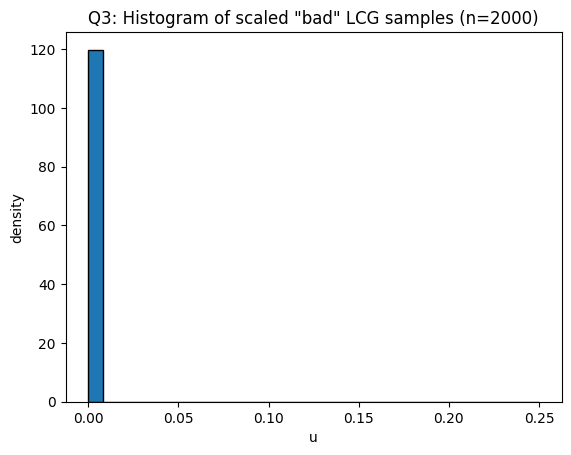

In [10]:
# Q3: "Bad" LCG parameters
# Choose m=1024 (power of 2), a=4, c=0 (multiplicative), seed=1 -> short period due to common factors
m_bad, a_bad, c_bad, x0_bad = 1024, 4, 0, 1
bad_period = lcg_period(a_bad, c_bad, m_bad, x0_bad, max_iter=100000)
x_bad = lcg(a_bad, c_bad, m_bad, x0_bad, 2000)
u_bad = np.array(x_bad, dtype=float) / m_bad

# KS test against U(0,1)
ks_stat, ks_p = stats.kstest(u_bad, 'uniform')

# Plot histogram for Q3
plt.figure()
plt.hist(u_bad, bins=30, density=True, edgecolor='black')
plt.title('Q3: Histogram of scaled "bad" LCG samples (n=2000)')
plt.xlabel('u')
plt.ylabel('density')
hist_q3_path = os.path.join("Q3_bad_lcg_hist.png")
plt.savefig(hist_q3_path, bbox_inches='tight')
plt.show()

In [11]:
print(ks_stat)
print(bad_period)

0.998
None


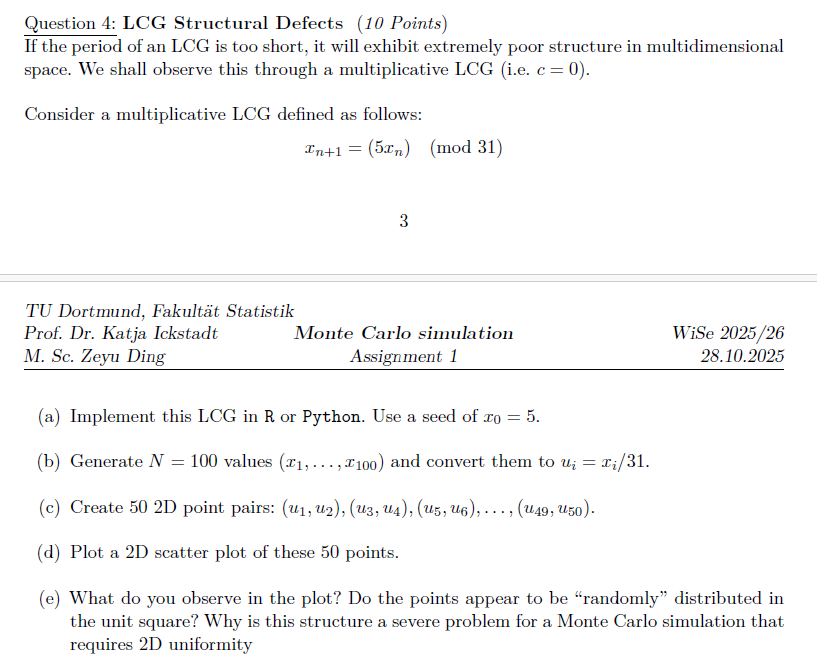

In [12]:
m_q4, a_q4, c_q4, x0_q4 = 31, 5, 0, 5
x_q4 = lcg(a_q4, c_q4, m_q4, x0_q4, 100)
u_q4 = scaling(x_q4,m_q4,100)

# Form 50 pairs (u[0],u[1]), (u[2],u[3]), ..., (u[98],u[99])
pairs = np.column_stack((u_q4[0::2], u_q4[1::2]))

# Sanity check
print(pairs.shape)   # (50, 2)
print(pairs[:5])     # show first 5 pairs

(50, 2)
[[0.80645161 0.03225806]
 [0.16129032 0.80645161]
 [0.03225806 0.16129032]
 [0.80645161 0.03225806]
 [0.16129032 0.80645161]]


In [13]:
u_q4[:10]

array([0.80645161, 0.03225806, 0.16129032, 0.80645161, 0.03225806,
       0.16129032, 0.80645161, 0.03225806, 0.16129032, 0.80645161])

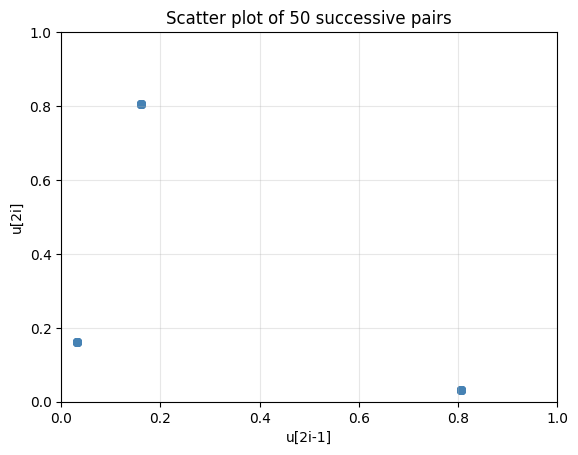

In [14]:
# Plot the pairs in 2D
plt.scatter(pairs[:,0], pairs[:,1], s=30, color='steelblue')
plt.title('Scatter plot of 50 successive pairs')
plt.xlabel('u[2i-1]')
plt.ylabel('u[2i]')
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True, alpha=0.3)
plt.show()

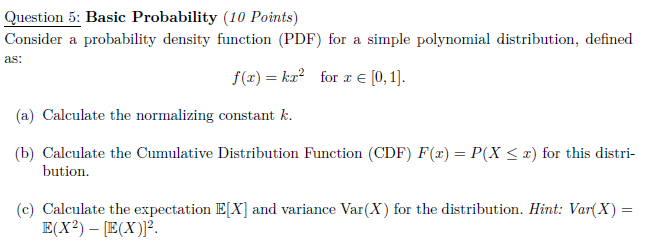

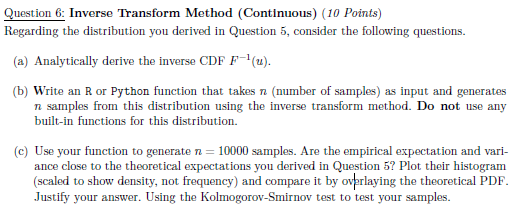

In [15]:
# b)
def sample_poly_x2(n, seed=None, rng=None):
    """
    Generate n samples from the distribution with pdf f(x)=3x^2 on [0,1]
    using the inverse transform method (no built-ins for this distribution).

    Inverse CDF: F^{-1}(u) = u^{1/3},  with  u ~ Uniform(0,1).

    Parameters
    ----------
    n : int
        Number of samples to generate.
    seed : int or None, optional
        If provided and rng is None, used to seed a fresh Generator.
    rng : np.random.Generator or None, optional
        If provided, use this RNG; otherwise create one (optionally with seed).

    Returns
    -------
    np.ndarray
        Array of shape (n,) with samples in [0,1].
    """
    if rng is None:
        rng = np.random.default_rng(seed)
    u = rng.random(n)          # Uniform(0,1)
    x = np.cbrt(u)             # u**(1/3) also fine
    return x

In [16]:
x = sample_poly_x2(10000, seed=42)
print(x.min(), x.max())           # should be in [0,1]
print(x.mean(), x.var())          # ~ 0.75 and ~ 0.0375

0.06799910927949186 0.9999923400805572
0.7484062333474683 0.03744322160988132


In [18]:
# Theoretical values
E_theory = 3/4          # 0.75
Var_theory = 3/5 - (3/4)**2  # 0.0375

# Generate samples
n = 10_000
x = sample_poly_x2(n, seed=123)

# Empirical stats
mean_emp = x.mean()
var_emp  = x.var(ddof=0)

print(f"Empirical mean  = {mean_emp:.5f} (theory {E_theory:.5f})")
print(f"Empirical var   = {var_emp:.5f} (theory {Var_theory:.5f})")

# KS test vs F(x)=x^3 on [0,1]
ks_stat, ks_p = stats.kstest(x, lambda t: t**3)
print(f"KS stat = {ks_stat:.5f}, p-value = {ks_p:.5g}")

Empirical mean  = 0.74737 (theory 0.75000)
Empirical var   = 0.03707 (theory 0.03750)
KS stat = 0.01541, p-value = 0.017123


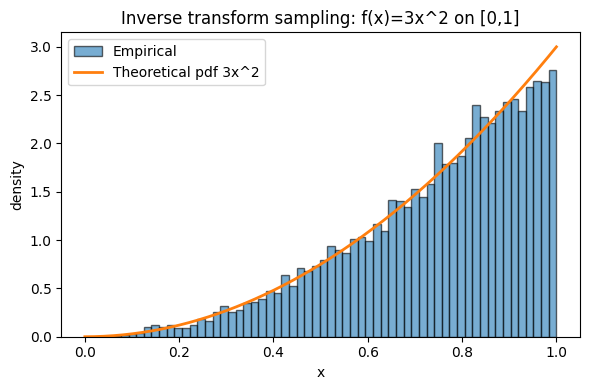

In [19]:
# Plot histogram with theoretical pdf 3x^2
xx = np.linspace(0,1,400)
plt.figure(figsize=(6,4))
plt.hist(x, bins=60, density=True, edgecolor='black', alpha=0.6, label='Empirical')
plt.plot(xx, 3*xx**2, linewidth=2, label='Theoretical pdf 3x^2')
plt.title('Inverse transform sampling: f(x)=3x^2 on [0,1]')
plt.xlabel('x'); plt.ylabel('density'); plt.legend()
plt.tight_layout()
plt.show()

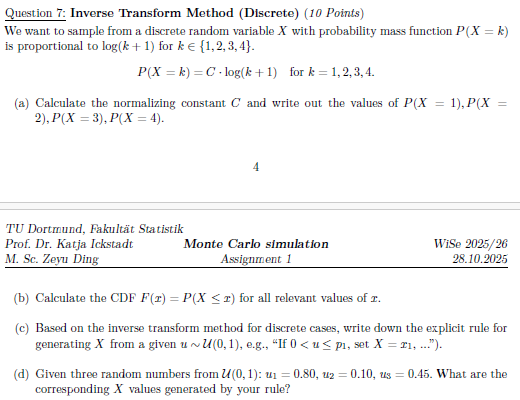



In [20]:
import numpy as np

# Step 1: probabilities from p_k ∝ log(k+1), k=1..4
def q7_probs():
    ks = np.array([1,2,3,4], dtype=int)
    w  = np.log(ks + 1.0)
    p  = w / w.sum()
    return ks, p

# Step 2: sample n values via discrete inverse transform
def q7_sample(n, seed=None, rng=None):
    ks, p = q7_probs()
    cdf = np.cumsum(p)
    if rng is None:
        rng = np.random.default_rng(seed)
    u = rng.random(n)
    # for each u, find the first index where cdf >= u
    idx = np.searchsorted(cdf, u, side="left")
    return ks[idx]

# Optional: map specific u-values to X
def q7_from_u(us):
    ks, p = q7_probs()
    cdf = np.cumsum(p)
    us = np.atleast_1d(us)
    idx = np.searchsorted(cdf, us, side="left")
    return ks[idx]

# Quick checks
ks, p = q7_probs()
print("k:", ks)
print("p_k:", p, "sum =", p.sum())
print("CDF:", np.cumsum(p))

print("Examples:", dict(zip([0.80, 0.10, 0.45], q7_from_u([0.80, 0.10, 0.45]))))

k: [1 2 3 4]
p_k: [0.14478295 0.22947555 0.2895659  0.3361756 ] sum = 1.0
CDF: [0.14478295 0.3742585  0.6638244  1.        ]
Examples: {0.8: np.int64(4), 0.1: np.int64(1), 0.45: np.int64(3)}


k:         [1 2 3 4]
theory p:  [0.144783 0.229476 0.289566 0.336176]
emp freq:  [0.1386 0.2281 0.2977 0.3356]


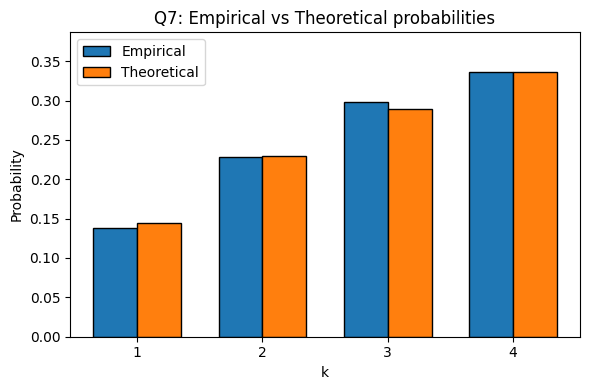

In [21]:
# (i) Theoretical probabilities p_k ∝ log(k+1), k=1..4
ks = np.array([1, 2, 3, 4], dtype=int)
w = np.log(ks + 1.0)
p = w / w.sum()  # normalize so probabilities sum to 1

# (ii) Discrete inverse-transform sampler
def q7_sample(n, seed=None, rng=None):
    """
    Draw n samples from the discrete distribution with p_k ∝ log(k+1)
    using the inverse transform method.
    """
    if rng is None:
        rng = np.random.default_rng(seed)
    cdf = np.cumsum(p)
    u = rng.random(n)
    idx = np.searchsorted(cdf, u, side="left")
    return ks[idx]

# (iii) Generate samples and empirical frequencies
n = 10_000
x = q7_sample(n, seed=2025)

counts = np.array([(x == k).sum() for k in ks])
emp = counts / n

print("k:        ", ks)
print("theory p: ", np.round(p, 6))
print("emp freq: ", np.round(emp, 6))

# (iv) Bar plot: empirical vs theoretical
width = 0.35
plt.figure(figsize=(6, 4))
plt.bar(ks - width / 2, emp, width=width, label='Empirical', edgecolor='black')
plt.bar(ks + width / 2, p, width=width, label='Theoretical', edgecolor='black')
plt.xticks(ks)
plt.ylim(0, max(emp.max(), p.max()) * 1.15)
plt.xlabel('k')
plt.ylabel('Probability')
plt.title('Q7: Empirical vs Theoretical probabilities')
plt.legend()
plt.tight_layout()
plt.show()

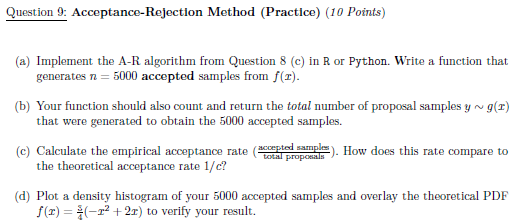

/tmp/ipython-input-849961477.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accepted.append(float(y))


Accepted samples: 5000
Total proposals: 7401
Empirical acceptance rate: 0.6756
Theoretical acceptance rate: 0.6667


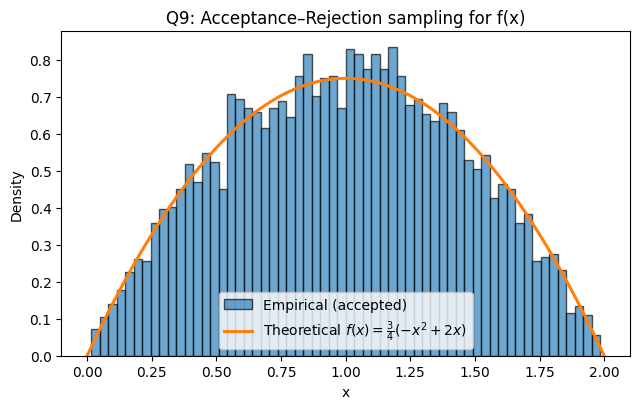

In [6]:
# -----------------------
# Target and proposal pdfs
# -----------------------
def f_target(x):
    """
    Target pdf: f(x) = (3/4)(-x^2 + 2x) for x in [0,2].
    Returns 0 outside this interval.
    """
    x = np.asarray(x, dtype=float)
    vals = (3/4) * (-x**2 + 2*x)
    vals[(x < 0) | (x > 2)] = 0
    return vals

def g_sample(rng, size=1):
    """Sample from proposal g(x) ~ Uniform(0,2)."""
    return rng.uniform(0, 2, size=size)

def g_pdf(x):
    """Proposal pdf g(x) for Uniform(0,2)."""
    x = np.asarray(x, dtype=float)
    out = np.zeros_like(x)
    out[(x >= 0) & (x <= 2)] = 0.5
    return out


# -----------------------
# Constants from Q8
# -----------------------
C_OPT = 1.5                # optimal c from Q8(b)
ACC_THEORY = 1 / C_OPT     # theoretical acceptance = 2/3


# -----------------------
# Acceptance–Rejection sampler
# -----------------------
def ar_sample_n(n_accept, seed=None):
    """
    Generate n_accept accepted samples using Acceptance–Rejection
    with proposal g ~ Uniform(0,2) and c = 3/2.

    Returns
    -------
    samples : np.ndarray
        Accepted samples (n_accept values).
    n_proposals : int
        Total number of proposals drawn.
    """
    rng = np.random.default_rng(seed)
    accepted = []
    n_proposals = 0

    while len(accepted) < n_accept:
        y = g_sample(rng)             # proposed sample
        u = rng.random()              # uniform(0,1)
        ratio = (-y**2 + 2*y)         # f(y)/(c*g(y)) simplifies to this
        n_proposals += 1
        if u <= ratio:
            accepted.append(float(y))

    return np.array(accepted), n_proposals


# -----------------------
# Helper functions
# -----------------------
def empirical_accept_rate(n_accept, n_proposals):
    """Compute acceptance rate = accepted / total proposals."""
    return n_accept / n_proposals


def plot_hist_with_theory(samples, bins=60, save_path=None):
    """Plot histogram of accepted samples with theoretical pdf."""
    xgrid = np.linspace(0, 2, 400)
    plt.figure(figsize=(6.5, 4.2))
    plt.hist(samples, bins=bins, density=True, alpha=0.65,
             edgecolor='black', label='Empirical (accepted)')
    plt.plot(xgrid, f_target(xgrid), linewidth=2.2,
             label='Theoretical $f(x)=\\frac{3}{4}(-x^2+2x)$')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.title('Q9: Acceptance–Rejection sampling for f(x)')
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


# -----------------------
# Run example
# -----------------------
n = 5000
samples, n_prop = ar_sample_n(n, seed=123)
emp_rate = empirical_accept_rate(n, n_prop)

print(f"Accepted samples: {len(samples)}")
print(f"Total proposals: {n_prop}")
print(f"Empirical acceptance rate: {emp_rate:.4f}")
print(f"Theoretical acceptance rate: {ACC_THEORY:.4f}")

plot_hist_with_theory(samples, bins=60, save_path="Q9_AR_hist.png")

Mean = -0.017399,  Variance = 1.023971


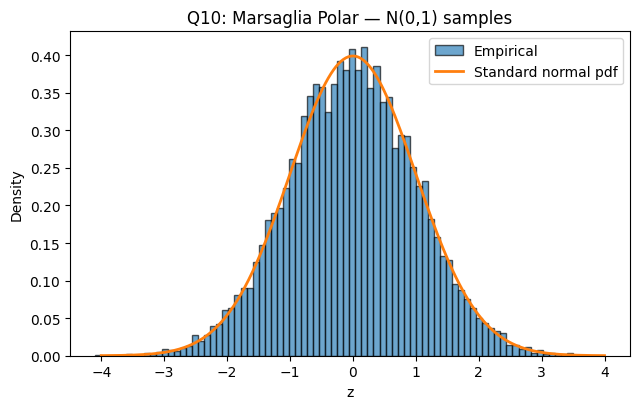

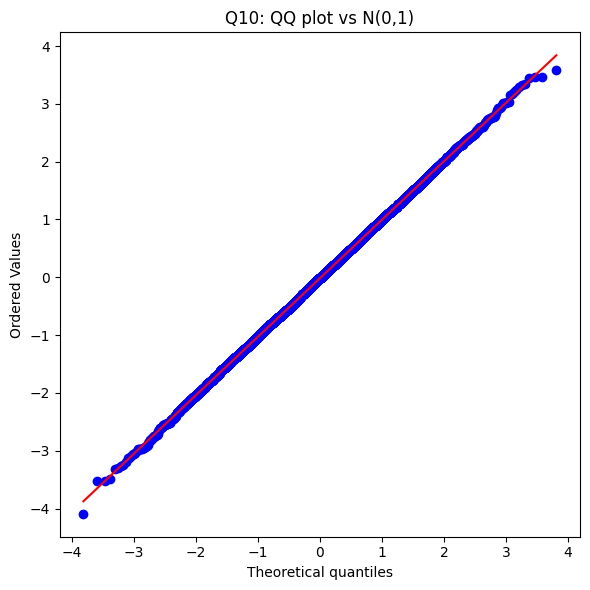

In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats
def marsaglia_polar(n, seed=None, rng=None):
    """
    Generate n samples from N(0,1) using Marsaglia's polar method.
    n must be even (each accepted pair returns two normals).
    """
    if n % 2 != 0:
        raise ValueError("n must be even")
    if rng is None:
        rng = np.random.default_rng(seed)

    out = np.empty(n, dtype=float)
    i = 0
    while i < n:
        u1 = rng.random()
        u2 = rng.random()
        v1 = 2.0 * u1 - 1.0
        v2 = 2.0 * u2 - 1.0
        s = v1*v1 + v2*v2
        if s == 0.0 or s >= 1.0:
            continue
        factor = math.sqrt(-2.0 * math.log(s) / s)
        out[i] = v1 * factor
        out[i+1] = v2 * factor
        i += 2
    return out

# -----------------------------
# Helpers for Q10 (b)-(d)
# -----------------------------
def summarize_normals(z):
    mean = z.mean()
    var = z.var(ddof=0)
    print(f"Mean = {mean:.6f},  Variance = {var:.6f}")
    return mean, var

def plot_hist_with_pdf(z, bins=80, save_path=None):
    x = np.linspace(-4, 4, 400)
    plt.figure(figsize=(6.5, 4.2))
    plt.hist(z, bins=bins, density=True, alpha=0.65, edgecolor='black', label='Empirical')
    plt.plot(x, stats.norm.pdf(x), linewidth=2.0, label='Standard normal pdf')
    plt.title('Q10: Marsaglia Polar — N(0,1) samples')
    plt.xlabel('z'); plt.ylabel('Density'); plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

def qq_plot(z, save_path=None):
    plt.figure(figsize=(6.0, 6.0))
    stats.probplot(z, dist="norm", plot=plt)
    plt.title('Q10: QQ plot vs N(0,1)')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# -----------------------------
# Example usage (uncomment to run)
# -----------------------------
n = 10_000
z = marsaglia_polar(n, seed=2025)
summarize_normals(z)
plot_hist_with_pdf(z, bins=80, save_path="Q10_polar_hist.png")
qq_plot(z, save_path="Q10_polar_qq.png")